# Tutorial

## Librerías 

Las librerías más importantes que se utilizan en este tutorial son las siguientes:
- OpenCv : Esta librería aporta diferentes funciones para poder manipular las imagenes y también permite utilizar distintos tipos de "pre-trainer" para poder detectar en este caso particular caras frontales.
- numpy : Esta librería nos permite un mejor manejo de arrays, ya que las imagenes estan representadas como matrices y esta librería tiene herramientas para manejarlas.
- Matplotlib : Esta librería nos facilita poder mostrar por pantalla las caras detectadas, gracias a las herramientas que tiene.
- Keras : Esta librería aporta modelos para el uso de las redes neuronales.

## Teoría :

Este programa toma imagenes, las cuales están representadas como matrices de pixeles y a través del método PCA permite tomar los datos más característicos de ésta para así determinar en primera instancia si hay un rostro o no, luego de determinar si es que encuentra un rostro, a través de redes neuronales que basicamente son distintos nodos conectados entre si que reciben cierta información y si es que un nodo se activa con cierto "peso" asignado procesa el dato y así mediante un entrenamiento da diseñado, este programa entrena esta red neuronal asignandole los "pesos" para poder determinar los puntos claves de un rostro, estos puntos pueden estar en la boca, nariz, ojos, etc.

### Primer paso:

En este primer paso se importan las librerías necesarias y definimos dos funciones, la primera busca una imagen en el directorio y cambia el color de ésta para que el modelo pueda reconocer los rostros en ella, retornando esta imagen modificada, la segunda función grafica la imagen y la muestra por pantalla.

In [5]:
# Importamos las librerías necesarias para este proyecto

%matplotlib inline

import numpy as np 
import matplotlib.pyplot as plt 
import math
import cv2 # Librería opencv que contiene funciones que permiten el uso de la visión aritificial                     
from PIL import Image # Permite manipular los distintos formatos de imagenes
import time

from keras.models import load_model # Permite importar un modelo para el uso de redes neuronales, con sus pesos y 
                                    # funciones de activación
    

def read_image(path): # Recibe una dirección de la imagen a analizar y retorna un archivo que se puede manipular con PIL
    """ Metodo para poder leer una imagen """
    image = cv2.imread(path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    return image

def plot_image(image, title=''): # Recibe la imagen a graficar y utilizando matplotlib la muestra en pantalla 
    """ Grafica la imagen """
    fig = plt.figure(figsize = (5,8))
    ax1 = fig.add_subplot(111)
    ax1.set_xticks([])
    ax1.set_yticks([])

    ax1.set_title(title)
    ax1.imshow(image)

Using TensorFlow backend.


### Segundo paso:

En este segundo paso definimos tres funciones necesarias para encontrar rostros en la imagen ingresada utilizando modelos definidos en la librería opencv, la primera función extrae de un archivo .xml un modelo que permite la detección de caras frontales, además de aplicar este modelo en la imagen y retornar un array con la información de las caras detectadas en la imagen, la segunda función grafica rectangulos sobre los rostros que fueron detectados y la tercera función grafica los puntos claves en un rostro sobre la imagen representados por puntos.

In [7]:
def get_faces(image):
    """
    Retorna un array con las caras detectadas
    Cada cara viene definida de la siguiente forma : top-left x, top-left y, width and height.
    """
    # Evitar que se sobreescriba 
    image_copy = np.copy(image)
    
    # Un filtro de color utilizado por opencv
    gray = cv2.cvtColor(image_copy, cv2.COLOR_RGB2GRAY)

    # Extrae un pre-trainer de un archivo xml
    face_classifier = cv2.CascadeClassifier('detectors/haarcascade_frontalface_default.xml')
    
    # Detecta las caras en la imagen
    faces = face_classifier.detectMultiScale(gray, 1.2, 5)
    
    return faces 

def draw_faces(image, faces=None, plot=True):
    """
    Grafica las caras detectadas en la imagen
    """
    if faces is None:
        faces = get_faces(image)
    
    # Evitar que se sobreescriba
    image_with_faces = np.copy(image)
    
    # Get the bounding box for each detected face
    for (x,y,w,h) in faces:
        # Add a red bounding box to the detections image
        cv2.rectangle(image_with_faces, (x,y), (x+w,y+h), (0,255,0), 5)
        
    if plot is True:
        plot_image(image_with_faces)
    else:
        return image_with_faces
    
    

def plot_image_with_keypoints(image, image_info):
    """
     Grafica los puntos representativos del rostro de la imagen dados por (x,y)
    """
    fig = plt.figure(figsize = (8,8))
    ax1 = fig.add_subplot(111)
    
    for (face, keypoints) in image_info:
        for (x,y) in keypoints:
            ax1.scatter(x, y, marker='o', c='c', s=10)
   

    ax1.set_xticks([])
    ax1.set_yticks([])
    ax1.imshow(image)

En el siguiente ejemplo utilizamos las funciones antes definidas para detectar los rostros y graficar rectangulos sobre ellos.

Faces detected: 1


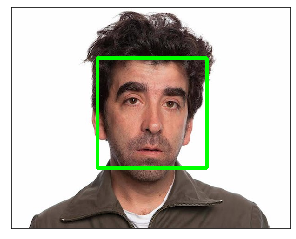

In [9]:
image = read_image('images/Pedro_Piedra/Pedro_Piedra_001.jpg')
faces = get_faces(image)
print("Faces detected: {}".format(len(faces)))
draw_faces(image, faces)

### Tercer paso:

En este paso se va a definir una red neuronal con la librería Keras para poder extraer los keypoints de las caras detectadas,Para poder hacer uso del conocimiento de la red neuronal hay que entrenarla con datos previos. En kaggle podemos encontrar este dataset que contiene 60MB de imágenes, cada una con un tag en los keypoints. Estos keypoints son 15 de los cuales 4 estan en la boca, 1 en la nariz, 3 en cada ojo y 2 en cada ceja.

In [11]:
from utils import *

# Load training set
# load_data es un método definido en el fichero utils para cargar las imágenes.
X_train, y_train = load_data()
print("X_train.shape == {}".format(X_train.shape))
print("y_train.shape == {}; y_train.min == {:.3f}; y_train.max == {:.3f}".format(
    y_train.shape, y_train.min(), y_train.max()))

# carga un conjunto de testeo
X_test, _ = load_data(test=True)
print("X_test.shape == {}".format(X_test.shape))

X_train.shape == (2140, 96, 96, 1)
y_train.shape == (2140, 30); y_train.min == -0.920; y_train.max == 0.996
X_test.shape == (1783, 96, 96, 1)


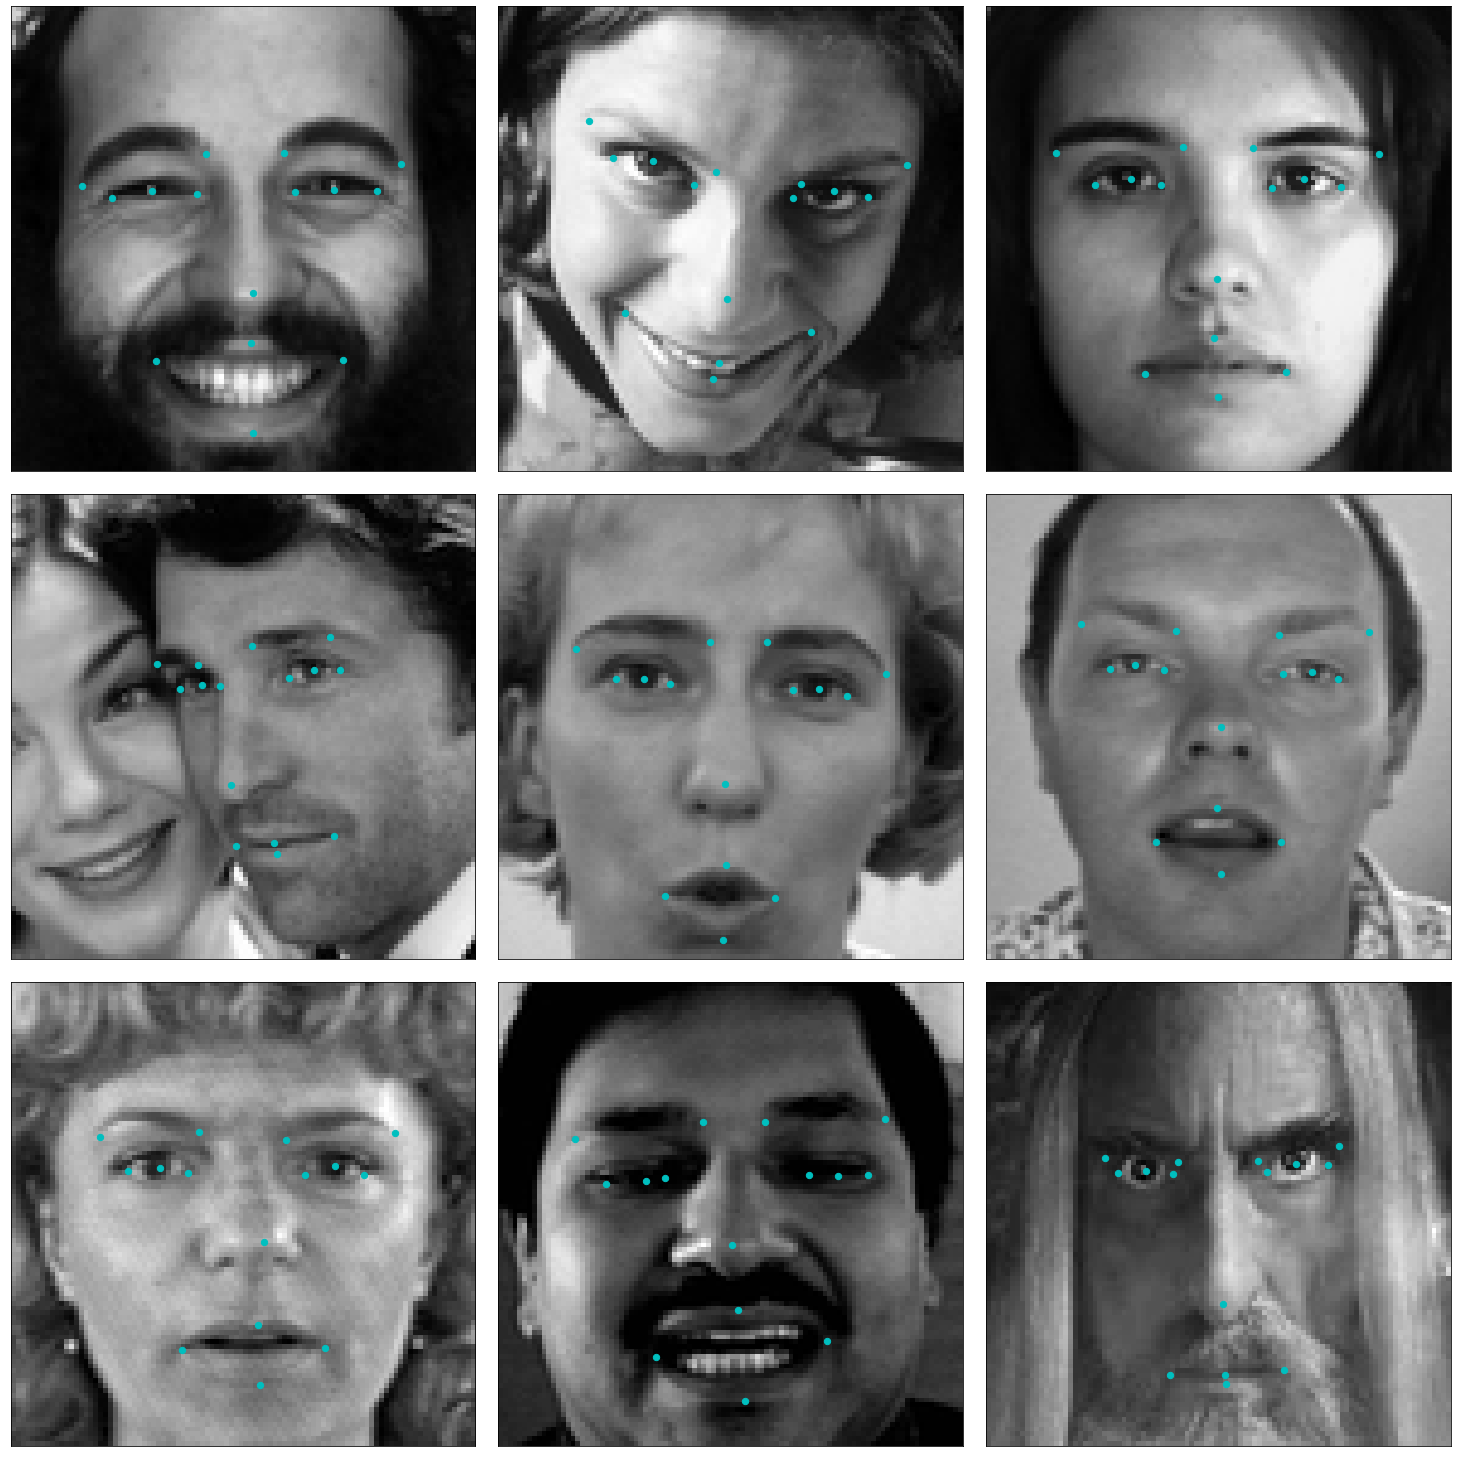

In [12]:
import matplotlib.pyplot as plt
%matplotlib inline

# Muestra los puntos los 15 keypoints de un rostro,  4 en la boca, 1 en la nariz, 3 en cada ojo y 2 en cada ceja. 
fig = plt.figure(figsize=(20,20))
fig.subplots_adjust(left=0, right=1, bottom=0, top=1, hspace=0.05, wspace=0.05)
for i in range(9):
    ax = fig.add_subplot(3, 3, i + 1, xticks=[], yticks=[])
    plot_data(X_train[i], y_train[i], ax)

In [13]:
# Importamos deep learning resources desde Keras
from keras.models import Sequential
from keras.layers import Convolution2D, MaxPooling2D, Dropout
from keras.layers import Flatten, Dense


# Debe tener una capa de salida totalmente conectada con 30 valores (2 para cada punto clave facial)
shape = (96,96)
model = Sequential()
model.add(Convolution2D(16,(2,2),padding='same',input_shape=(96,96, 1), activation='relu'))
model.add(MaxPooling2D(pool_size=3))

model.add(Convolution2D(32,(3,3),padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=3))
model.add(Dropout(0.2))

model.add(Convolution2D(64,(3,3),padding='same',activation='relu'))
model.add(MaxPooling2D(pool_size=3))
model.add(Dropout(0.2))

model.add(Convolution2D(128,(3,3),padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=3))
model.add(Dropout(0.2))

model.add(Flatten())
model.add(Dense(256,activation='relu'))
model.add(Dropout(0.2))


model.add(Dense(30))


# Resumen del modelo
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 96, 96, 16)        80        
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 32, 32, 16)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 32, 32, 32)        4640      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 10, 10, 32)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 10, 10, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 10, 10, 64)        18496     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 3, 3, 64)          0         
__________

### Cuarto paso:


En este paso definimos dos funciones, la primera entrena el modelo que luego utilizaremos para detectar los keypoints, y la segunda permite visualizar los datos perdidos en el entrenamiento.

In [14]:
from keras.optimizers import SGD, RMSprop, Adagrad, Adadelta, Adam, Adamax, Nadam
from keras.callbacks import ModelCheckpoint, History  

epochs = 50
histo = History()

def compile_model(model, epochs):
    
    filepath = 'model.hdf5'
    model.compile(optimizer='adam', loss='mse', metrics=['accuracy'])

    checkpointer = ModelCheckpoint(filepath=filepath, 
                                   verbose=1, save_best_only=True)

    ## entranamiento del modelo
    hist = model.fit(X_train, y_train, validation_split=0.2,
              epochs=epochs, batch_size=20, callbacks=[checkpointer, histo], verbose=1)
    
    model.save(filepath)
    
    return hist

def show_training_validation_loss(hist, epochs):
    plt.plot(range(epochs), hist.history[
             'val_loss'], 'g-', label='Val Loss')
    plt.plot(range(epochs), hist.history[
             'loss'], 'g--', label='Train Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show() 

# Establezca True si desea entrenar la red. Obtendrá valores de red preentrenados de un archivo.
train_net = False

if train_net is True:
    hist = compile_model(model, epochs) 
else:
    model.load_weights('model.hdf5')

In [15]:
if train_net is True:
    show_training_validation_loss(hist, epochs)

### Quinto paso:

En este paso definimos las funciones que nos permiten detectar los keypoints, en el caso de get_keypoints obtener los keypoints en los rostros encontrados previamente en la imagen y retorna un array con las ubicaciones de estos keypoints en la imagen, la segunda función grafica los keypoints en la imagen que fue ingresada y la tercera función muestra todas las características que logramos detectar en este tutorial con las funciones tambien previamente definidas.

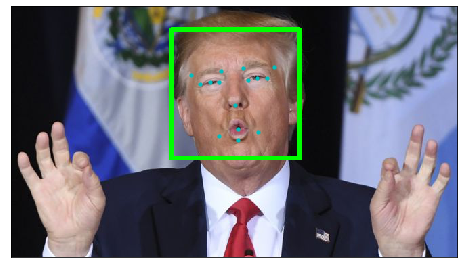

In [17]:
def get_keypoints(image, faces=None):
    
    # Lista de pares (cara,keypoint)
    result = []
    
    if faces is None:
        faces = get_faces(image)
    
    # Igualamos el tamaño con el utilizado para el entrenamiento
    faces_shape = (96, 96)
    
    # Evitar que se sobreescriba
    image_copy = np.copy(image)
    
    # Para cada cara, detectamos puntos clave y mostramos su infomación
    for (x,y,w,h) in faces:

        # recortamos la región de la cara
        face = image_copy[y:y+h,x:x+w]

        # cambiamos nuevamente el tamaño y la escala de colores a grises
        gray_face = cv2.cvtColor(face, cv2.COLOR_BGR2GRAY)
        resize_gray_face = cv2.resize(gray_face, faces_shape) / 255

        inputs = np.expand_dims(np.expand_dims(resize_gray_face, axis=-1), axis=0)
                                
        # Obtenemos un keypoint                       
        predicted_keypoints = model.predict(inputs)

        # dejamos todos los keypoint en un array
        predicted_keypoints = np.squeeze(predicted_keypoints)
        
        keypoints = []        
        for idx in range(0, len(predicted_keypoints), 2):
            
            x_scale_factor = face.shape[0]/faces_shape[0] 
            y_scale_factor = face.shape[1]/faces_shape[1] 

            x_center_left_offset = predicted_keypoints[idx] * faces_shape[0]/2 + faces_shape[0]/2 
            y_center_left_offset = predicted_keypoints[idx + 1] * faces_shape[1]/2 + faces_shape[1]/2
            
            x_center = int(x + (x_scale_factor * x_center_left_offset))
            y_center = int(y + (y_scale_factor * y_center_left_offset))

            keypoints.append([x_center, y_center])
        
        result.append([(x,y,w,h), keypoints])
    
    return result

def show_image_and_features(image_path):
    image = read_image(image_path)
    faces = get_faces(image)
    keypoints = get_keypoints(image, faces)
    image_with_faces = draw_faces(image, faces ,plot=False)
    plot_image_with_keypoints(image_with_faces, keypoints)
    
    # Ejemplo que muestra los datos que logramos obtener de una imagen con un rostro frontal
show_image_and_features('images/Donald_Trump/Donald_Trump_001.jpg')

### Posibles mejoras

Las posibles mejoras que le veo a este tutorial, pueden ser agregar una base de datos que permita determinar quien es la persona que sale en la imagen, guardando sus keypoints y luego ver la distancia que existe entre ellos para así quizas determinar un umbral apropiado para determinar la identidad del sujeto, otra mejora quizas es agregar otros modelos aparte del de caras frontales utilizado, para poder identificar rostros en diferentes posiciones.